## A model that allows searching for objects in one category within another selected category.The images for the categories are downloaded from DuckDuckGo. The model used is ResNet-18 and we fine-tune it.

Firstly, we'll need to install some libraries. This may take a few minutes.

In [97]:
import os
import random
from pathlib import Path
from fastai.vision.all import *
import matplotlib.pyplot as plt

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler

## Step 1: Download images of envirionment and the things you want to look in the envirionment

This is a code for setting up the crawler that'll get us images from the internet.

In [98]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

Apart from the crawler, we'll also set up a search_images function for the sake of ease. This function will get images from the internet and download it.

In [99]:
# We'll define a search_images function for the sake of ease

def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

Let's start by searching for a computer photo and seeing what kind of result we get.

In [100]:
search_images("computer", 1)

Searching for 'computer'


Let's take a look at the photo we downloaded:

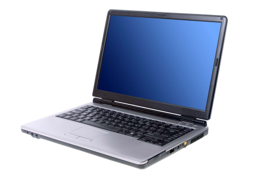

In [101]:
from fastai.vision.all import *
im = Image.open("computer000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

Looks great! Now let's get a desk photo as well.

In [102]:
search_images("desk", 1)

Searching for 'desk'


Let's look at the desk photo:

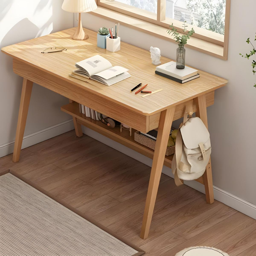

In [103]:
im = Image.open("desk000001.png")
im.to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "computer" and "desk" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [104]:
no_of_photos = 200 # This represents the number of photos that'll be downloaded for each category.

searches = 'desk','computer'
path = Path('computer_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)  # Pause between searches to avoid over-loading server
    search_images(f"{o} sun photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{o} night photo", no_of_photos, dest) 
    # Changed this to get "night photo" instead of "shade photo" since the original would cause paint tones to be downloaded 
    sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

Searching for 'desk photo'
Searching for 'desk sun photo'
Searching for 'desk night photo'
Photos of desk completed!
Searching for 'computer photo'


Exception in thread parser-001:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/icrawler/parser.py", line 94, in worker_exec
    for task in self.parse(response, **kwargs):
TypeError: 'NoneType' object is not iterable


Searching for 'computer sun photo'


Exception in thread parser-001:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/icrawler/parser.py", line 94, in worker_exec
    for task in self.parse(response, **kwargs):
TypeError: 'NoneType' object is not iterable


Searching for 'computer night photo'
Photos of computer completed!
Photos resized!


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [105]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

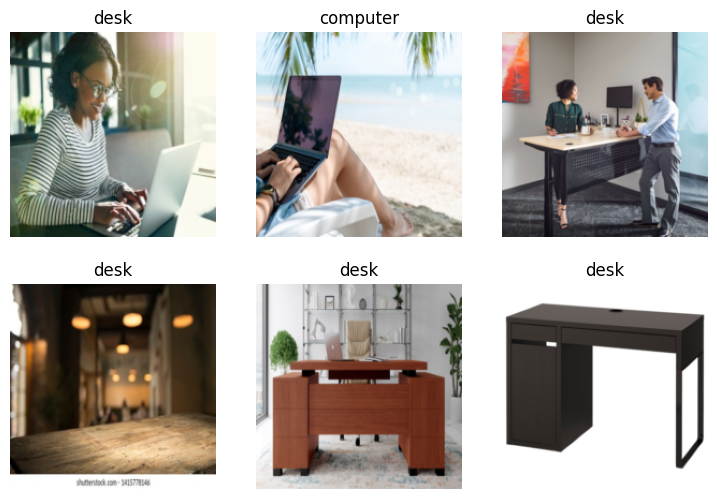

In [106]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "computer" or "desk").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *computer* or *desk*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [107]:
from fastai.callback.tracker import EarlyStoppingCallback

# Model eğitimi
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(34, cbs=[EarlyStoppingCallback(monitor='error_rate', patience=5)])


epoch,train_loss,valid_loss,error_rate,time
0,1.216179,0.858417,0.449153,00:02
1,1.032507,0.586468,0.245763,00:02
2,0.884810,0.492814,0.194915,00:02
3,0.753230,0.462009,0.161017,00:02
4,0.654280,0.443727,0.169492,00:02
5,0.544575,0.483498,0.177966,00:02
6,0.462583,0.519491,0.177966,00:02
7,0.378880,0.511006,0.152542,00:02
8,0.318834,0.520175,0.169492,00:02
9,0.271955,0.493143,0.161017,00:02


No improvement since epoch 12: early stopping


Let's see what our model thinks about that computer we downloaded at the start:

In [108]:
is_computer,_,probs = learn.predict(PILImage.create('computer000001.png'))
print(f"This is a: {is_computer}.")
print(f"Probability it's a computer: {probs[0]:.4f}")

This is a: computer.
Probability it's a computer: 1.0000


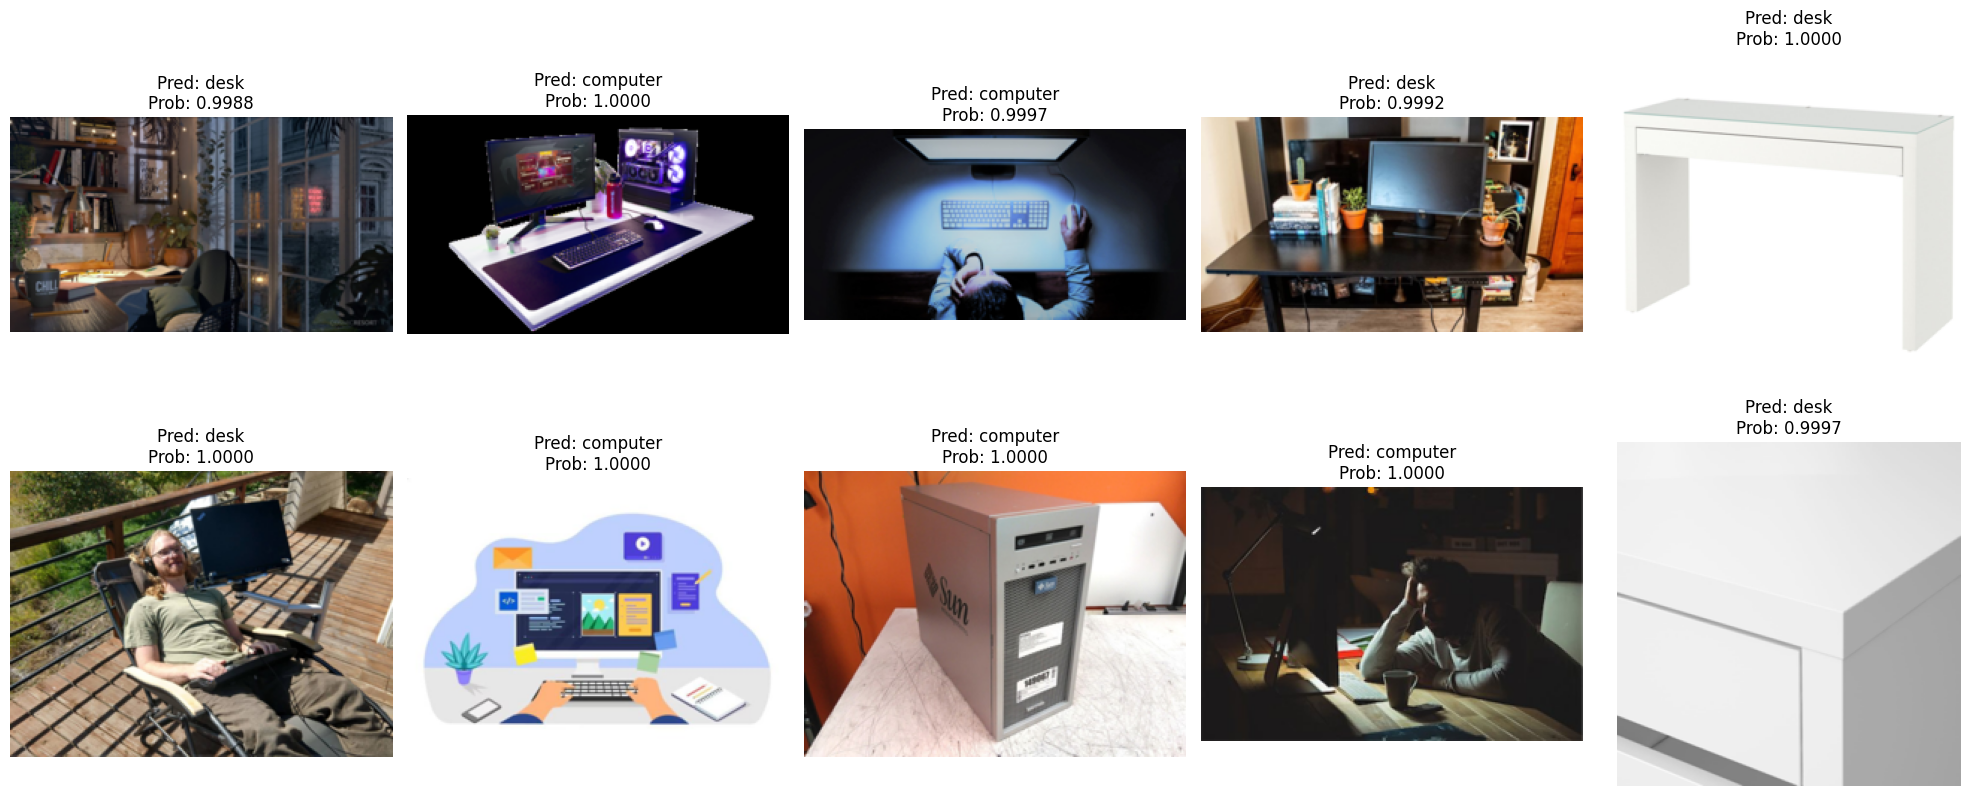

In [109]:
def get_random_images(path, num_images=10):
    all_images = list(get_image_files(path))
    random_images = random.sample(all_images, num_images)
    return random_images

random_images = get_random_images(path, 10)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for img_path, ax in zip(random_images, axes):
    img = PILImage.create(img_path)
    pred_class, pred_idx, probs = learn.predict(img)
    ax.imshow(img.to_thumb(256, 256))
    ax.set_title(f"Pred: {pred_class}\nProb: {probs[pred_idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
